<a href="https://colab.research.google.com/github/sv650s/sb-capstone/blob/master/2019_07_23_CNN_Multi_layer_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Multi-Layer Prototype

Based on the [single layer notebook](https://github.com/sv650s/sb-capstone/blob/master/2019-06-23-CNN_prototype.ipynb), we will add a couple convolution layers to see if we get better results

Because the previous notebooks were rather large, I put some of the common code for gather metrics and plotting into utility modules that are loaded below

Source code for the modules are here:
* [dict_util](https://github.com/sv650s/sb-capstone/blob/master/util/dict_util.py)
* [plot_util](https://github.com/sv650s/sb-capstone/blob/master/util/plot_util.py)
* [keras_util](https://github.com/sv650s/sb-capstone/blob/master/util/keras_util.py)

In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive')
# add this to sys patch so we can import utility functions
sys.path.append('drive/My Drive/Springboard/capstone')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from sklearn.preprocessing import OneHotEncoder
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
import pandas as pd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pickle
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report
import os
import seaborn as sns

# custom utilities
import util.dict_util as du
import util.plot_util as pu
import util.keras_util as ku


sns.set()

DRIVE_DIR = "drive/My Drive/Springboard/capstone"
DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-preprocessed-110k.csv"
FEATURE_COLUMN = "star_rating"
REVIEW_COLUMN = "review_body"



Using TensorFlow backend.


In [0]:
# load data file
df = pd.read_csv(f"{DATA_FILE}")

# extract feature and label columns
rating = df[FEATURE_COLUMN]
reviews = df[REVIEW_COLUMN]

# Preprocessing

Same as previous notebooks but consolidated to one cell to make thing easier to understand

Features:
* tokenize our review body - this gives us:
  * vocab size: 40788 words
* then we will pad the sequences to length 186 since this encapsulates 99% of the lenght of our training data

Labels:
* one hot encode our star rating labels (y)


In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder


# pre-process our lables
# one hot encode our star ratings since Keras/TF requires this for the labels
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()


# split our data into train and test sets
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, y, random_state=1)


# Pre-process our features (review body)
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(reviews_train)
# tokenize both our training and test data
train_sequences = t.texts_to_sequences(reviews_train)
test_sequences = t.texts_to_sequences(reviews_test)

print("Vocabulary size={}".format(len(t.word_counts)))
print("Number of Documents={}".format(t.document_count))

# figure out 99% percentile for our max sequence length
df["review_length"] = df.review_body.apply(lambda x: len(x.split()))
MAX_SEQUENCE_LENGTH = int(df.review_length.quantile([0.99]).values[0])
print(f'Max Sequence Length: {MAX_SEQUENCE_LENGTH}')

# pad our reviews to the max sequence length
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)



/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Vocabulary size=40788
Number of Documents=84032
Max Sequence Length: 186


## Build Our 2 Layer Model

* we will use embedding size of 300 since this gave us slight improvement from previous notebook for class 1 and 2

In [0]:
MODEL_NAME = "CNN_2layer"
EMBED_SIZE = 300
EPOCHS  = 50
BATCH_SIZE = 128
VOCAB_SIZE = len(t.word_counts)+1


In [6]:
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


W0724 05:55:15.958377 139643119421312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0724 05:55:15.978696 139643119421312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0724 05:55:15.982407 139643119421312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0724 05:55:16.034923 139643119421312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0724 05:55:16.074673 139643119421312 deprecation_wrapp

In [7]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 186, 300)          12236700  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 186, 100)          90100     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 186, 100)          30100     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 93, 100)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9300)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               2325250   
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1255      
Total para

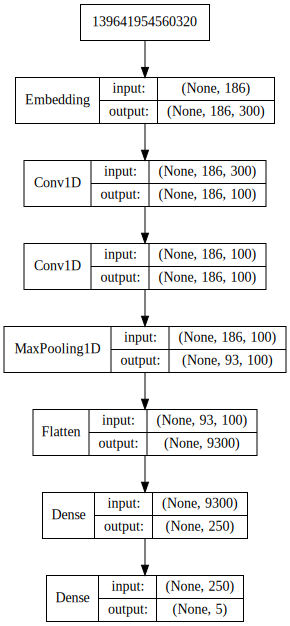

In [8]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [9]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
network_history = model.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      callbacks=[early_stop])

W0724 05:55:16.372010 139643119421312 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0724 05:55:16.494192 139643119421312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 67225 samples, validate on 16807 samples
Epoch 1/50
67225/67225 [==============================] - 386s 6ms/step - loss: 0.9331 - acc: 0.6428 - val_loss: 0.8556 - val_acc: 0.6706
Epoch 2/50
67225/67225 [==============================] - 386s 6ms/step - loss: 0.7369 - acc: 0.7108 - val_loss: 0.8466 - val_acc: 0.6728
Epoch 3/50
67225/67225 [==============================] - 386s 6ms/step - loss: 0.6149 - acc: 0.7613 - val_loss: 0.9180 - val_acc: 0.6708
Epoch 4/50
67225/67225 [==============================] - 386s 6ms/step - loss: 0.4917 - acc: 0.8106 - val_loss: 1.1412 - val_acc: 0.6349
Epoch 00004: early stopping


## Evaluate our 2 Layer Model

* look at accuracy scores
* epoch vs loss and accuarcy
* confusion matrix
* ROC/AUC plot

In [10]:
# get scores
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

28011/28011 [==============================] - 39s 1ms/step
Accuracy: 63.66%


In [20]:
from importlib import reload

drive.mount('/content/drive', force_remount=True)
# add this to sys patch so we can import utility functions
sys.path.append('drive/My Drive/Springboard/capstone')

import util.plot_util as pu



Mounted at /content/drive


In [21]:
pu.plot_network_history(network_history)

AttributeError: ignored

In [0]:
y_predict = model.predict(X_test)
y_predict_unencoded = ku.unencode(y_predict)
y_test_unencoded = ku.unencode(y_test)

In [0]:
cm = confusion_matrix(y_test_unencoded, y_predict_unencoded)
cm

In [0]:
print(classification_report(y_test_unencoded, y_predict_unencoded))

In [0]:
roc_auc, fpr, tpr = calculate_roc_auc(y_test, y_predict_df)
fig = plt.figure(figsize=(5,5))
plot_roc_auc(MODEL_NAME, roc_auc, fpr, tpr)

## Save off files for our 2 layer model

In [0]:
directory, INBASENAME = fu.get_dir_basename(DATA_FILE)
DESCRIPTION = f"{INBASENAME}-nosmote-{MODEL_NAME}-{MAX_SEQUENCE_LENGTH}-{FEATURE_COLUMN}"
MODEL_FILE = f"{DRIVE_DIR}/models/{datetime.now().strftime(DATE_FORMAT)}-{DESCRIPTION}.h5"
NETWORK_HISTORY_FILE = f'{DRIVE_DIR}/models/{datetime.now().strftime(DATE_FORMAT)}-{DESCRIPTION}-history.pkl'
REPORT_FILE = f"{DRIVE_DIR}/reports/{datetime.now().strftime(DATE_FORMAT)}-DNN_protype-report.csv"
TOKENIZER_FILE = f'{DRIVE_DIR}/models/{datetime.now().strftime(DATE_FORMAT)}-{DESCRIPTION}-tokenizer.pkl'

model.save(MODEL_FILE)
pickle.dump(network_history, open(NETWORK_HISTORY_FILE, "wb"))
pickle.dump(t, open(TOKENIZER_FILE, "wb"))

## Generate and save our 2 layer report

In [0]:
# generate report dictionary
report = {}
report = du.add_dict_to_dict(report, classification_report(y_test_unencoded, y_predict_unencoded, output_dict=True))
report = du.add_dict_to_dict(report, roc_auc)
report["confusion_matrix"] = cm
report["tpr"] = tpr
report["fpr"] = fpr
report["loss"] = scores[0]
report["accuracy"] = scores[1]
report["description"] = DESCRIPTION
report["file"] = DATA_FILE
report["network_history_file"] = NETWORK_HISTORY_FILE
report["tokenizer_file"] = TOKENIZER_FILE
report["max_sequence_length"] = MAX_SEQUENCE_LENGTH
report["embedding"] = EMBED_SIZE
report["model_file"] = MODEL_FILE
report["model_name"] = MODEL_NAME
report["test_examples"] = X_test.shape[0]
report["test_features"] = X_test.shape[1]
report["train_examples"] = X_train.shape[0]
report["train_features"] = X_train.shape[1]
report["status"] = "success"
report["status_date"] = datetime.now().strftime(TIME_FORMAT)

In [0]:
# check to see if report file exisits, if so load it and append
exists = os.path.isfile(REPORT_FILE)
if exists:
    report_df = pd.read_csv(REPORT_FILE)
else:
    report_df = pd.DataFrame()
    
report_df = report_df.append(report, ignore_index=True)
report_df.head(20)
# save report
report_df.to_csv(REPORT_FILE, index=False)

